In [6]:
import pandas as pd
import os
import glob
import numpy as np

# =============================================================================
# --- Configuration ---
# =============================================================================
# The folder containing your 24 TRAINING subject CSV files.
TRAINING_DATA_FOLDER = './csv_folder/' 

# The name for our final, master training dataset file.
OUTPUT_TRAINING_CSV = 'master_training_dataset_imputed.csv'

# The subject ID that has the missing channel.
SUBJECT_WITH_MISSING_DATA = 'EPCTL05'
# The channel that is missing.
MISSING_CHANNEL = 'F4'
# The neighboring channels we will use for imputation.
NEIGHBOR_CHANNELS = ['Fp2', 'C4', 'F8']

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting: Consolidating data with Smart Subject ID Correction ---")

# --- 1. Find and Load All Training CSV Files ---
search_path = os.path.join(TRAINING_DATA_FOLDER, '*.csv')
all_subject_files = glob.glob(search_path)

if not all_subject_files:
    print(f"ERROR: No CSV files found in {TRAINING_DATA_FOLDER}")
    exit()

print(f"Found {len(all_subject_files)} subject CSV files to merge.")
list_of_dataframes = []

# --- 2. Load Files and Assign Correct Subject IDs ---
# This is the new, smarter loop.
print("Loading files and assigning correct Subject IDs from filenames...")
for f in all_subject_files:
    # Extract the base filename (e.g., 'EPCTL05_features_channelwise.csv')
    base_name = os.path.basename(f)
    # Extract the subject ID from the filename (e.g., 'EPCTL05')
    subject_id = base_name.split('_')[0]
    
    # Read the CSV file
    df = pd.read_csv(f)
    
    # **THE FIX:** Ignore the old subject_id column and create a new,
    # correct one based on the filename.
    if 'subject_id' in df.columns:
        df = df.drop(columns=['subject_id'])
    df['subject_id'] = subject_id
    
    list_of_dataframes.append(df)
    print(f"  - Loaded data for subject: {subject_id}")


# --- 3. Merge DataFrames, Keeping All Columns ---
print("\nMerging all dataframes (this will create NaN values)...")
master_df = pd.concat(list_of_dataframes, ignore_index=True, join='outer')
print("Merge complete.")

# --- 4. Perform Spatial Imputation for the Missing Channel ---
print(f"\n--- Performing Spatial Imputation for Subject: {SUBJECT_WITH_MISSING_DATA} ---")

f4_columns = [col for col in master_df.columns if col.startswith(f'{MISSING_CHANNEL}_')]

if master_df[f4_columns].isnull().sum().sum() > 0:
    print(f"Found {len(f4_columns)} features for channel {MISSING_CHANNEL} that need imputation.")
    
    for f4_col in f4_columns:
        base_feature = '_'.join(f4_col.split('_')[1:])
        neighbor_cols = [f'{neighbor}_{base_feature}' for neighbor in NEIGHBOR_CHANNELS]
        
        if all(col in master_df.columns for col in neighbor_cols):
            imputed_values = master_df[neighbor_cols].mean(axis=1)
            master_df[f4_col].fillna(imputed_values, inplace=True)
            print(f"  - Imputed missing values for: {f4_col}")
        else:
            print(f"  - WARNING: Could not find all neighbor columns for {f4_col}. Skipping.")
            
    final_missing_count = master_df[f4_columns].isnull().sum().sum()
    if final_missing_count == 0:
        print("\n--- Imputation Successful ---")
    else:
        print(f"\n--- Imputation Incomplete ---")

else:
    print("No missing values found for F4 columns. No imputation was needed.")

# --- 5. Save the Master Dataset ---
print(f"\nSaving the imputed master training dataset to: {OUTPUT_TRAINING_CSV}")
master_df.to_csv(OUTPUT_TRAINING_CSV, index=False)
print("File saved successfully.")

print("\n--- Consolidation Complete ---")
print(f"Your final training dataset has {master_df.shape[0]} rows (epochs)")
print(f"and {master_df.shape[1]} columns (features + labels).")
print("It now contains the full feature set with corrected Subject IDs and no missing values.")


--- Starting: Consolidating data with Smart Subject ID Correction ---
Found 24 subject CSV files to merge.
Loading files and assigning correct Subject IDs from filenames...
  - Loaded data for subject: EPCTL02
  - Loaded data for subject: EPCTL03
  - Loaded data for subject: EPCTL05
  - Loaded data for subject: EPCTL06
  - Loaded data for subject: EPCTL07
  - Loaded data for subject: EPCTL09
  - Loaded data for subject: EPCTL10
  - Loaded data for subject: EPCTL11
  - Loaded data for subject: EPCTL12
  - Loaded data for subject: EPCTL13
  - Loaded data for subject: EPCTL14
  - Loaded data for subject: EPCTL15
  - Loaded data for subject: EPCTL16
  - Loaded data for subject: EPCTL17
  - Loaded data for subject: EPCTL18
  - Loaded data for subject: EPCTL19
  - Loaded data for subject: EPCTL20
  - Loaded data for subject: EPCTL22
  - Loaded data for subject: EPCTL23
  - Loaded data for subject: EPCTL24
  - Loaded data for subject: EPCTL26
  - Loaded data for subject: EPCTL27
  - Loaded da

--- Starting Deep Exploratory Data Analysis for the Master Dataset ---
Successfully loaded the master dataset.
Shape of the data: 21683 rows (epochs), 102 columns (features)

--- [A] Data Integrity and Structure ---
Verifying data types and checking for missing values...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21683 entries, 0 to 21682
Columns: 102 entries, subject_id to eog_std
dtypes: float64(99), int64(1), object(2)
memory usage: 16.9+ MB

SUCCESS: Your dataset has no missing values.

--- [B] Deep Analysis of Sleep Stage Distribution (Class Balance) ---
Distribution of sleep stages across all subjects:
             Count  Percentage
sleep_stage                   
N2            8226       37.94
Wake          5302       24.45
N3            3676       16.95
REM           2488       11.47
N1            1991        9.18


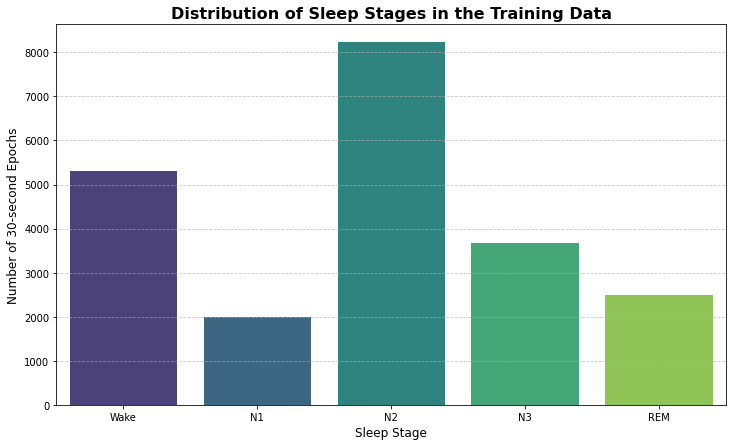


--- [C] Deep Analysis of Key Feature Effectiveness ---
Using Violin Plots to show the full distribution of feature values per stage.


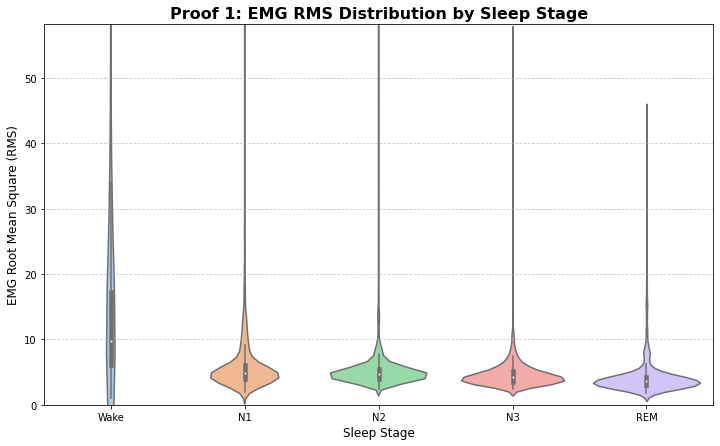

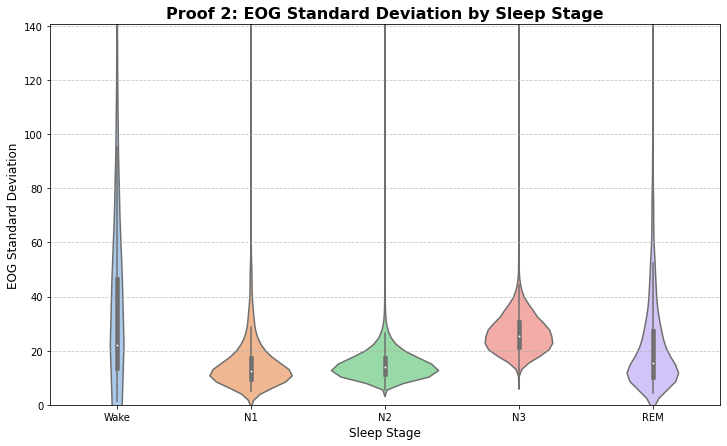


--- [D] Analyzing EEG Spectral Fingerprints ---


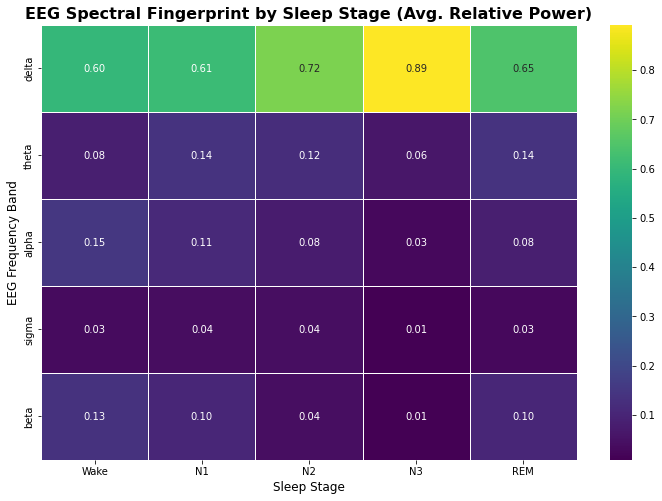


--- [E] Analyzing Feature Correlations ---


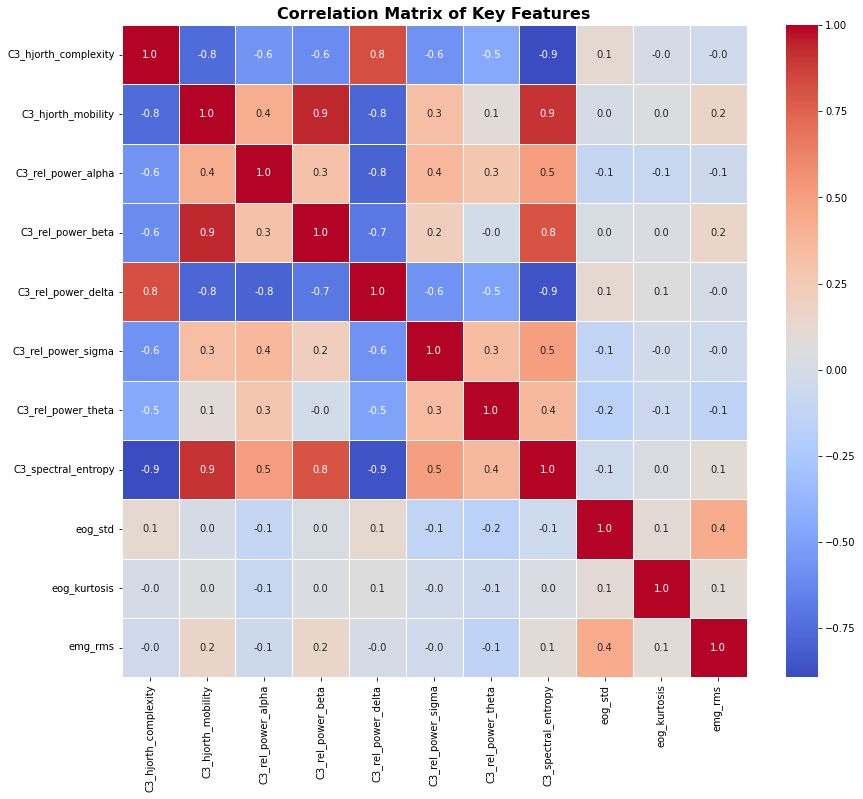


--- FINAL PREPROCESSING PLAN (BASED ON DEEP ANALYSIS) ---
1. SEPARATE FEATURES AND LABELS:
   - X = df.drop(columns=['subject_id', 'sleep_stage', 'is_rem'])
   - y = df['sleep_stage'] (or df['is_rem'] for binary classification)

2. LABEL ENCODING:
   - The 'sleep_stage' column must be converted to numbers. A LabelEncoder is perfect for this.

3. FEATURE SCALING (Standardization):
   - Our features have vastly different scales. Using `StandardScaler` from scikit-learn is essential for most models.

4. HANDLE CLASS IMBALANCE (CRITICAL):
   - Our analysis shows a significant imbalance (lots of N2, very little N1/N3).
   - STRONGLY RECOMMENDED: Use a technique like SMOTE (Synthetic Minority Over-sampling TEchnique) on your training data to create synthetic examples of the rare classes. This will help prevent the model from just ignoring them.
   - Alternatively, use the `class_weight='balanced'` parameter in models like RandomForest or LogisticRegression.

5. TRAIN/VALIDATION SPLIT:
   - 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# --- Configuration ---
# =============================================================================
# The master dataset file we created in the last step.
MASTER_CSV_PATH = 'master_training_dataset_imputed.csv'

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================
print("--- Starting Deep Exploratory Data Analysis for the Master Dataset ---")

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv(MASTER_CSV_PATH)
    print(f"Successfully loaded the master dataset.")
    print(f"Shape of the data: {df.shape[0]} rows (epochs), {df.shape[1]} columns (features)")
except FileNotFoundError:
    print(f"ERROR: The file was not found at: {MASTER_CSV_PATH}")
    print("Please make sure the file from the previous step exists.")
    exit()

# --- 2. Data Integrity and Structure ---
print("\n--- [A] Data Integrity and Structure ---")
print("Verifying data types and checking for missing values...")
df.info(verbose=False) # A concise summary of the dataframe
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("\nSUCCESS: Your dataset has no missing values.")
else:
    print(f"\nWARNING: Your dataset has {missing_values} missing values that need to be addressed.")

# --- 3. Deep Analysis of Sleep Stage Distribution ---
print("\n--- [B] Deep Analysis of Sleep Stage Distribution (Class Balance) ---")
stage_counts = df['sleep_stage'].value_counts()
stage_percentages = df['sleep_stage'].value_counts(normalize=True) * 100
stage_dist = pd.DataFrame({'Count': stage_counts, 'Percentage': stage_percentages.round(2)})
print("Distribution of sleep stages across all subjects:")
print(stage_dist)

plt.figure(figsize=(12, 7))
sns.countplot(x='sleep_stage', data=df, order=['Wake', 'N1', 'N2', 'N3', 'REM'], palette='viridis')
plt.title('Distribution of Sleep Stages in the Training Data', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('Number of 30-second Epochs', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 4. Deep Analysis of Key Features ---
print("\n--- [C] Deep Analysis of Key Feature Effectiveness ---")
print("Using Violin Plots to show the full distribution of feature values per stage.")

# Proof 1: EMG RMS (Should be very low for REM)
plt.figure(figsize=(12, 7))
sns.violinplot(x='sleep_stage', y='emg_rms', data=df, order=['Wake', 'N1', 'N2', 'N3', 'REM'], palette='pastel')
plt.title('Proof 1: EMG RMS Distribution by Sleep Stage', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EMG Root Mean Square (RMS)', fontsize=12)
plt.ylim(bottom=0, top=df['emg_rms'].quantile(0.99))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Proof 2: EOG Standard Deviation (Should be high for REM and Wake)
plt.figure(figsize=(12, 7))
sns.violinplot(x='sleep_stage', y='eog_std', data=df, order=['Wake', 'N1', 'N2', 'N3', 'REM'], palette='pastel')
plt.title('Proof 2: EOG Standard Deviation by Sleep Stage', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EOG Standard Deviation', fontsize=12)
plt.ylim(bottom=0, top=df['eog_std'].quantile(0.99))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Proof 3: EEG Spectral "Fingerprints" (The Brain State)
print("\n--- [D] Analyzing EEG Spectral Fingerprints ---")
# We will calculate the average power for each band in each stage
eeg_power_cols = [col for col in df.columns if 'rel_power' in col]
eeg_fingerprints = df.groupby('sleep_stage')[eeg_power_cols].mean()
# To make it easier to visualize, we'll average across all channels for the plot
bands = ['delta', 'theta', 'alpha', 'sigma', 'beta']
plot_data = pd.DataFrame()
for band in bands:
    band_cols = [col for col in eeg_fingerprints.columns if band in col]
    plot_data[band] = eeg_fingerprints[band_cols].mean(axis=1)

plot_data = plot_data.reindex(['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.figure(figsize=(12, 8))
sns.heatmap(plot_data.T, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title('EEG Spectral Fingerprint by Sleep Stage (Avg. Relative Power)', fontsize=16, weight='bold')
plt.xlabel('Sleep Stage', fontsize=12)
plt.ylabel('EEG Frequency Band', fontsize=12)
plt.show()

# --- 5. Feature Correlation Analysis ---
print("\n--- [E] Analyzing Feature Correlations ---")
# We'll select a subset of key features for a readable correlation matrix
# Let's use all features from one central channel (C3) plus our EOG/EMG features
corr_cols = [col for col in df.columns if 'C3_' in col] + ['eog_std', 'eog_kurtosis', 'emg_rms']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Key Features', fontsize=16, weight='bold')
plt.show()


# --- 6. The Final Preprocessing Plan ---
print("\n" + "="*60)
print("--- FINAL PREPROCESSING PLAN (BASED ON DEEP ANALYSIS) ---")
print("="*60)
print("1. SEPARATE FEATURES AND LABELS:")
print("   - X = df.drop(columns=['subject_id', 'sleep_stage', 'is_rem'])")
print("   - y = df['sleep_stage'] (or df['is_rem'] for binary classification)")
print("\n2. LABEL ENCODING:")
print("   - The 'sleep_stage' column must be converted to numbers. A LabelEncoder is perfect for this.")
print("\n3. FEATURE SCALING (Standardization):")
print("   - Our features have vastly different scales. Using `StandardScaler` from scikit-learn is essential for most models.")
print("\n4. HANDLE CLASS IMBALANCE (CRITICAL):")
print("   - Our analysis shows a significant imbalance (lots of N2, very little N1/N3).")
print("   - STRONGLY RECOMMENDED: Use a technique like SMOTE (Synthetic Minority Over-sampling TEchnique) on your training data to create synthetic examples of the rare classes. This will help prevent the model from just ignoring them.")
print("   - Alternatively, use the `class_weight='balanced'` parameter in models like RandomForest or LogisticRegression.")
print("\n5. TRAIN/VALIDATION SPLIT:")
print("   - Remember to split your data into training and validation sets AFTER preprocessing to prevent data leakage.")

print("\n--- Deep Analysis Complete ---")



--- Starting Model Building and Evaluation ---

--- Loading Data ---
Loaded training data: 21683 epochs
Loaded and combined 3 test subjects: 2592 epochs

--- Preprocessing: Encoding Labels ---
Labels encoded. Class order: ['N1', 'N2', 'N3', 'REM', 'Wake']

--- Preprocessing: Scaling Features ---

--- Handling Class Imbalance with SMOTE ---
Original training data shape: (21683, 99)
Resampled training data shape: (41130, 99)

--- Training Model 1: Random Forest ---

--- Performance Report for: Random Forest ---
Overall Accuracy: 0.7724 (77.24%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.33      0.29      0.31       252
          N2       0.81      0.86      0.83      1019
          N3       0.90      0.80      0.85       474
         REM       0.65      0.65      0.65       329
        Wake       0.86      0.88      0.87       518

    accuracy                           0.77      2592
   macro avg       0.71      0.70      0.70    

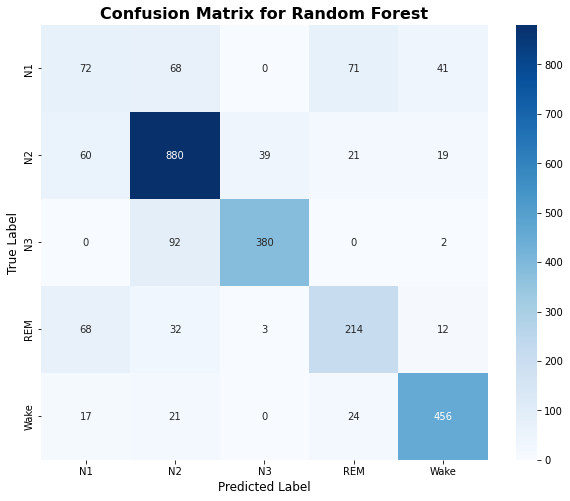


--- Training Model 2: XGBoost ---


C:\Users\reddy\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



--- Performance Report for: XGBoost ---
Overall Accuracy: 0.7782 (77.82%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.36      0.28      0.32       252
          N2       0.79      0.84      0.81      1019
          N3       0.89      0.79      0.84       474
         REM       0.70      0.78      0.74       329
        Wake       0.88      0.88      0.88       518

    accuracy                           0.78      2592
   macro avg       0.72      0.71      0.72      2592
weighted avg       0.77      0.78      0.77      2592


Confusion Matrix:


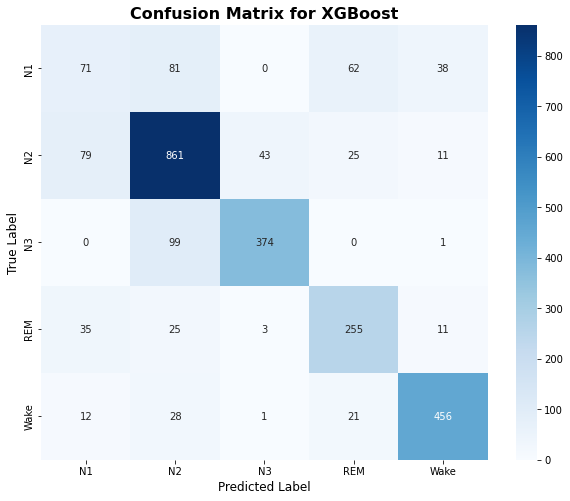


--- Training Model 3: LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25245
[LightGBM] [Info] Number of data points in the train set: 41130, number of used features: 99
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438

--- Performance Report for: LightGBM ---
Overall Accuracy: 0.7639 (76.39%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.35      0.33      0.34       252
          N2       0.78      0.83      0.80      1019
          N3       0.88      0.72      0.79       474
         REM       0.70      0.78      0.74       329
        Wake       0.88      0.88

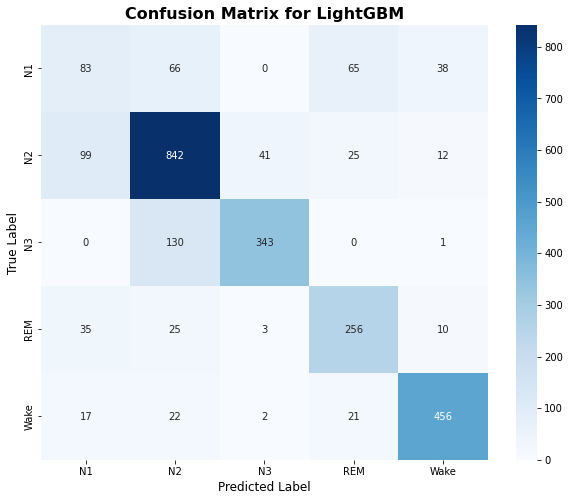


--- Training Model 4: Support Vector Machine (SVC) ---

--- Performance Report for: Support Vector Machine ---
Overall Accuracy: 0.7704 (77.04%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.32      0.37      0.34       252
          N2       0.84      0.81      0.82      1019
          N3       0.87      0.85      0.86       474
         REM       0.65      0.67      0.66       329
        Wake       0.90      0.88      0.89       518

    accuracy                           0.77      2592
   macro avg       0.71      0.72      0.71      2592
weighted avg       0.78      0.77      0.78      2592


Confusion Matrix:


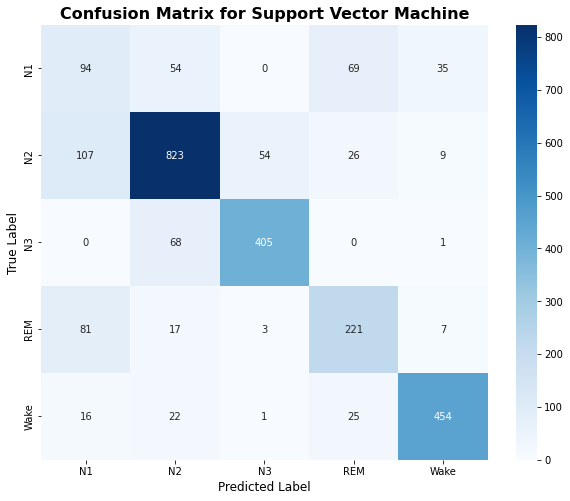


--- Training Model 5: Logistic Regression ---

--- Performance Report for: Logistic Regression ---
Overall Accuracy: 0.7647 (76.47%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.32      0.37      0.34       252
          N2       0.84      0.81      0.83      1019
          N3       0.84      0.86      0.85       474
         REM       0.61      0.66      0.63       329
        Wake       0.91      0.85      0.88       518

    accuracy                           0.76      2592
   macro avg       0.70      0.71      0.71      2592
weighted avg       0.77      0.76      0.77      2592


Confusion Matrix:


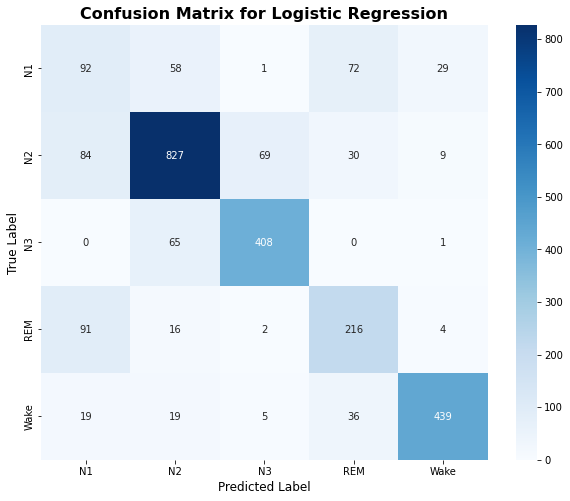


--- Modeling Complete ---


In [3]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Core ML Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Models ---
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# --- Imbalance Handling ---
from imblearn.over_sampling import SMOTE

# =============================================================================
# --- Configuration ---
# =============================================================================
# The master training dataset file.
TRAINING_CSV_PATH = 'master_training_dataset_imputed.csv'
# The folder containing your 3 UNSEEN TEST subject CSV files.
TEST_DATA_FOLDER = './test_subjects/'

# We will focus on the multi-class problem first.
TARGET_COLUMN = 'sleep_stage'

# =============================================================================
# --- Helper Function for Evaluation ---
# =============================================================================
def evaluate_model(model, X_test, y_test, class_names, model_name="Model"):
    """
    Generates a full performance report for a trained classifier.
    """
    print("\n" + "="*60)
    print(f"--- Performance Report for: {model_name} ---")
    print("="*60)
    
    # Make predictions on the unseen test data
    y_pred = model.predict(X_test)
    
    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    # Print the detailed classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)
    
    # Plot the confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16, weight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting Model Building and Evaluation ---")

# --- 1. Load and Prepare Data ---
print("\n--- Loading Data ---")
# Load training data
try:
    train_df = pd.read_csv(TRAINING_CSV_PATH)
    print(f"Loaded training data: {train_df.shape[0]} epochs")
except FileNotFoundError:
    print(f"ERROR: Training file not found at {TRAINING_CSV_PATH}")
    exit()

# Load and combine test data
search_path = os.path.join(TEST_DATA_FOLDER, '*.csv')
test_files = glob.glob(search_path)
if not test_files:
    print(f"ERROR: No test CSV files found in {TEST_DATA_FOLDER}")
    exit()
test_df = pd.concat([pd.read_csv(f) for f in test_files], ignore_index=True)
print(f"Loaded and combined {len(test_files)} test subjects: {test_df.shape[0]} epochs")

# --- 2. Preprocessing: Separate Features and Labels ---
# Ensure columns are aligned between train and test sets
common_cols = list(set(train_df.columns) & set(test_df.columns))
train_df = train_df[common_cols]
test_df = test_df[common_cols]

# Define feature columns (everything except identifiers and labels)
feature_cols = [col for col in train_df.columns if col not in ['subject_id', 'sleep_stage', 'is_rem']]

X_train = train_df[feature_cols]
y_train_text = train_df[TARGET_COLUMN]

X_test = test_df[feature_cols]
y_test_text = test_df[TARGET_COLUMN]

# --- 3. Preprocessing: Label Encoding ---
print("\n--- Preprocessing: Encoding Labels ---")
le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
y_test = le.transform(y_test_text)
class_names = le.classes_
print(f"Labels encoded. Class order: {list(class_names)}")

# --- 4. Preprocessing: Feature Scaling ---
print("\n--- Preprocessing: Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # IMPORTANT: Use the scaler fitted on the training data

# --- 5. Handling Class Imbalance with SMOTE ---
print("\n--- Handling Class Imbalance with SMOTE ---")
print(f"Original training data shape: {X_train_scaled.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Resampled training data shape: {X_train_resampled.shape}")

# --- 6. Train and Evaluate Models ---
# --- Model 1: Random Forest ---
print("\n--- Training Model 1: Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)
evaluate_model(rf_model, X_test_scaled, y_test, class_names, "Random Forest")

# --- Model 2: XGBoost ---
print("\n--- Training Model 2: XGBoost ---")
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(class_names),
                              use_label_encoder=False, eval_metric='mlogloss', 
                              random_state=42, n_jobs=-1)
xgb_model.fit(X_train_resampled, y_train_resampled)
evaluate_model(xgb_model, X_test_scaled, y_test, class_names, "XGBoost")

# --- Model 3: LightGBM ---
print("\n--- Training Model 3: LightGBM ---")
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=len(class_names),
                               random_state=42, n_jobs=-1)
lgb_model.fit(X_train_resampled, y_train_resampled)
evaluate_model(lgb_model, X_test_scaled, y_test, class_names, "LightGBM")

# --- Model 4: Support Vector Machine (SVC) ---
print("\n--- Training Model 4: Support Vector Machine (SVC) ---")
svc_model = SVC(random_state=42)
svc_model.fit(X_train_resampled, y_train_resampled)
evaluate_model(svc_model, X_test_scaled, y_test, class_names, "Support Vector Machine")

# --- Model 5: Logistic Regression ---
print("\n--- Training Model 5: Logistic Regression ---")
lr_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
lr_model.fit(X_train_resampled, y_train_resampled)
evaluate_model(lr_model, X_test_scaled, y_test, class_names, "Logistic Regression")


print("\n--- Modeling Complete ---")



In [7]:
import pandas as pd
import numpy as np

# =============================================================================
# --- Configuration ---
# =============================================================================
# The master dataset file we just created with corrected IDs.
INPUT_FEATURES_CSV = 'master_training_dataset_imputed.csv'

# The name for our new, more powerful dataset with temporal features.
OUTPUT_TEMPORAL_CSV = 'master_training_dataset_temporal.csv'

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting Advanced Feature Engineering: Adding Temporal Features ---")

# --- 1. Load the Master Dataset ---
try:
    df = pd.read_csv(INPUT_FEATURES_CSV)
    print(f"Successfully loaded the master dataset with {df.shape[0]} epochs.")
except FileNotFoundError:
    print(f"ERROR: The file was not found at: {INPUT_FEATURES_CSV}")
    exit()

# --- 2. Prepare for Temporal Feature Creation ---
# Define the columns that we will create lagged versions of.
# We exclude identifiers and labels.
feature_cols = [col for col in df.columns if col not in ['subject_id', 'sleep_stage', 'is_rem']]

# --- 3. Group by Subject and Create Lagged Features ---
# This is the most critical step. We must perform this operation separately
# for each subject to prevent data leakage between recordings.
print("\nGrouping by subject to create temporal features...")
all_subjects_data = []
# The groupby() function creates a separate mini-dataframe for each subject.
for subject, subject_df in df.groupby('subject_id'):
    print(f"  - Processing subject: {subject}")
    
    # We assume the data for each subject is in the correct chronological order.
    subject_df = subject_df.reset_index(drop=True)
    
    # --- Create features from the PREVIOUS epoch ---
    # The .shift(1) method moves the data down by one row.
    prev_epoch_features = subject_df[feature_cols].shift(1)
    # Rename the columns to indicate they are from the previous epoch.
    prev_epoch_features.columns = [f'{col}_prev' for col in feature_cols]
    
    # --- Create features from the NEXT epoch ---
    # The .shift(-1) method moves the data up by one row.
    next_epoch_features = subject_df[feature_cols].shift(-1)
    # Rename the columns.
    next_epoch_features.columns = [f'{col}_next' for col in feature_cols]
    
    # --- Combine the original, previous, and next features ---
    combined_df = pd.concat([subject_df, prev_epoch_features, next_epoch_features], axis=1)
    
    # --- Handle Missing Values at the Edges ---
    # The very first epoch of a night has no "previous" epoch, and the last
    # has no "next". This creates NaN values. We will fill them using the
    # 'backfill' and 'forwardfill' methods, which is a standard practice.
    combined_df.fillna(method='bfill', inplace=True)
    combined_df.fillna(method='ffill', inplace=True)
    
    all_subjects_data.append(combined_df)

# --- 4. Assemble the Final Temporal Dataset ---
# Combine the processed data from all subjects back into one master dataframe.
temporal_df = pd.concat(all_subjects_data, ignore_index=True)
print("\nSuccessfully created temporal features for all subjects.")

# --- 5. Verification and Save ---
# Let's check the new shape of our data. It should have many more columns.
print(f"Original number of features: {len(feature_cols)}")
print(f"New number of features (original + prev + next): {len(feature_cols) * 3}")
print(f"Shape of the final temporal dataset: {temporal_df.shape}")

print(f"\nSaving the new temporal feature set to: {OUTPUT_TEMPORAL_CSV}")
temporal_df.to_csv(OUTPUT_TEMPORAL_CSV, index=False)
print("File saved successfully.")

print("\n--- Temporal Feature Engineering Complete ---")
print("This new dataset now has 'memory' and is ready for advanced modeling.")



--- Starting Advanced Feature Engineering: Adding Temporal Features ---
Successfully loaded the master dataset with 21683 epochs.

Grouping by subject to create temporal features...
  - Processing subject: EPCTL02
  - Processing subject: EPCTL03
  - Processing subject: EPCTL05
  - Processing subject: EPCTL06
  - Processing subject: EPCTL07
  - Processing subject: EPCTL09
  - Processing subject: EPCTL10
  - Processing subject: EPCTL11
  - Processing subject: EPCTL12
  - Processing subject: EPCTL13
  - Processing subject: EPCTL14
  - Processing subject: EPCTL15
  - Processing subject: EPCTL16
  - Processing subject: EPCTL17
  - Processing subject: EPCTL18
  - Processing subject: EPCTL19
  - Processing subject: EPCTL20
  - Processing subject: EPCTL22
  - Processing subject: EPCTL23
  - Processing subject: EPCTL24
  - Processing subject: EPCTL26
  - Processing subject: EPCTL27
  - Processing subject: EPCTL28
  - Processing subject: EPCTL29

Successfully created temporal features for all su

--- Starting Final Model Showdown with Temporal Features ---

--- Loading Data ---
Loaded temporal training data: 21683 epochs
Loaded and combined 3 raw test subjects: 2592 epochs
Creating temporal features for the test set...
Temporal features for test set created successfully.

--- Preprocessing: Encoding Labels ---
Labels encoded. Class order: ['N1', 'N2', 'N3', 'REM', 'Wake']

--- Preprocessing: Scaling Features ---

--- Handling Class Imbalance with SMOTE ---
Original training data shape: (21683, 297)
Resampled training data shape: (41130, 297)

--- Training Model 1: Random Forest ---

--- Performance Report for: Random Forest (Temporal) ---
Overall Accuracy: 0.7921 (79.21%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.38      0.31      0.34       252
          N2       0.82      0.87      0.85      1019
          N3       0.92      0.81      0.86       474
         REM       0.68      0.74      0.71       329
        Wake    

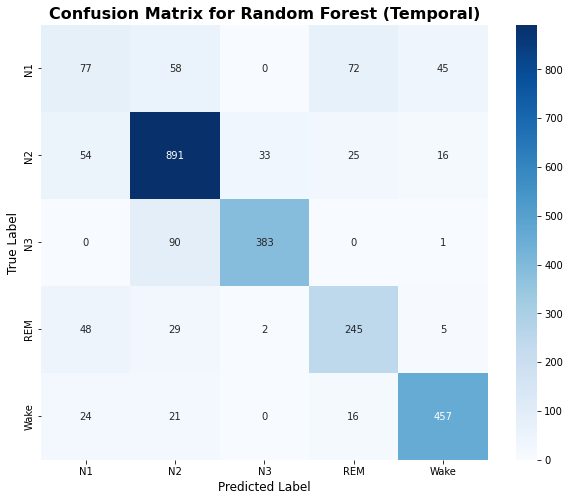


--- Training Model 2: XGBoost ---


C:\Users\reddy\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



--- Performance Report for: XGBoost (Temporal) ---
Overall Accuracy: 0.7824 (78.24%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.41      0.31      0.35       252
          N2       0.78      0.87      0.82      1019
          N3       0.89      0.73      0.80       474
         REM       0.72      0.82      0.77       329
        Wake       0.89      0.88      0.88       518

    accuracy                           0.78      2592
   macro avg       0.74      0.72      0.72      2592
weighted avg       0.78      0.78      0.78      2592


Confusion Matrix:


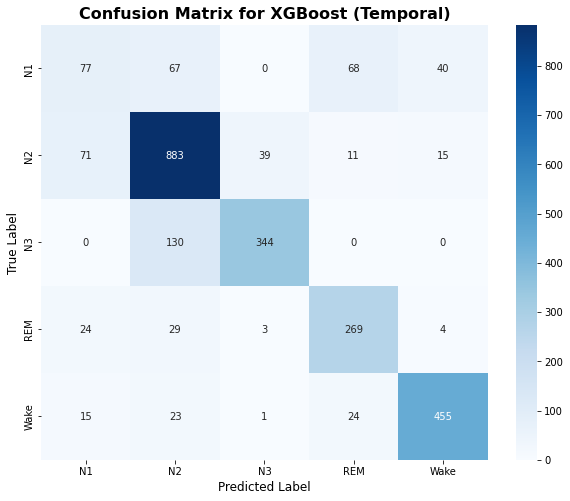


--- Training Model 3: LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75735
[LightGBM] [Info] Number of data points in the train set: 41130, number of used features: 297
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438

--- Performance Report for: LightGBM (Temporal) ---
Overall Accuracy: 0.7836 (78.36%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.40      0.38      0.39       252
          N2       0.79      0.86      0.82      1019
          N3       0.90      0.73      0.80       474
         REM       0.75      0.78      0.76       329
        Wake       0.

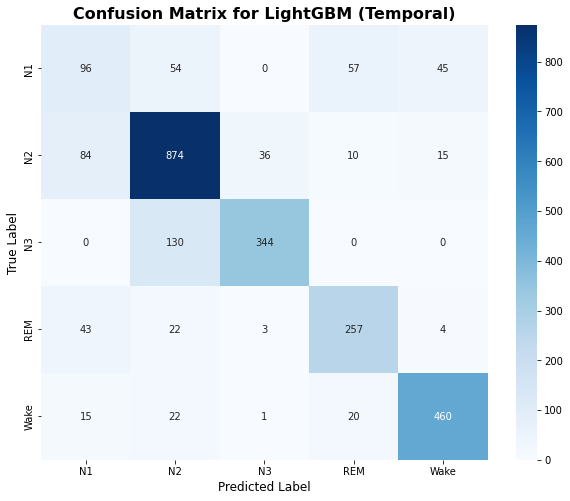


--- Training Model 4: Support Vector Machine (SVC) ---

--- Performance Report for: Support Vector Machine (Temporal) ---
Overall Accuracy: 0.7836 (78.36%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.34      0.40      0.37       252
          N2       0.83      0.83      0.83      1019
          N3       0.89      0.85      0.87       474
         REM       0.71      0.68      0.70       329
        Wake       0.89      0.89      0.89       518

    accuracy                           0.78      2592
   macro avg       0.73      0.73      0.73      2592
weighted avg       0.79      0.78      0.79      2592


Confusion Matrix:


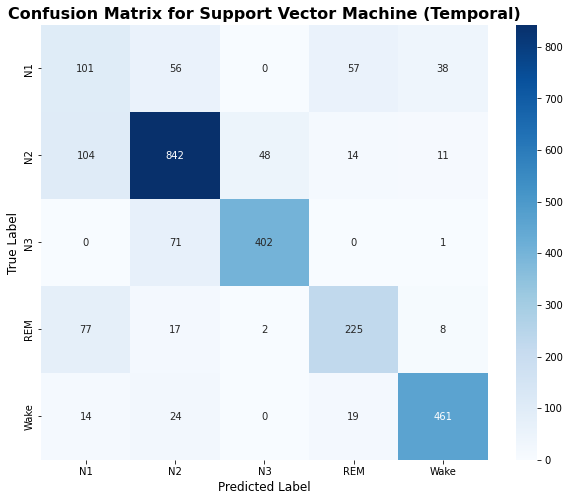


--- Training Model 5: Logistic Regression ---

--- Performance Report for: Logistic Regression (Temporal) ---
Overall Accuracy: 0.7689 (76.89%)

Classification Report:
              precision    recall  f1-score   support

          N1       0.34      0.41      0.37       252
          N2       0.83      0.82      0.83      1019
          N3       0.86      0.85      0.85       474
         REM       0.65      0.67      0.66       329
        Wake       0.91      0.83      0.87       518

    accuracy                           0.77      2592
   macro avg       0.72      0.72      0.72      2592
weighted avg       0.78      0.77      0.77      2592


Confusion Matrix:


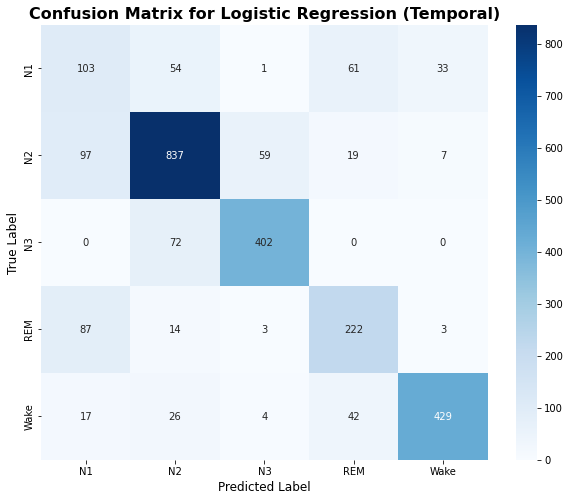


--- FINAL MODEL SHOWDOWN: PERFORMANCE COMPARISON ---
                            Model  Accuracy  REM_F1_Score
         Random Forest (Temporal)  0.792052      0.713246
              LightGBM (Temporal)  0.783565      0.763744
Support Vector Machine (Temporal)  0.783565      0.698758
               XGBoost (Temporal)  0.782407      0.767475
   Logistic Regression (Temporal)  0.768904      0.659733


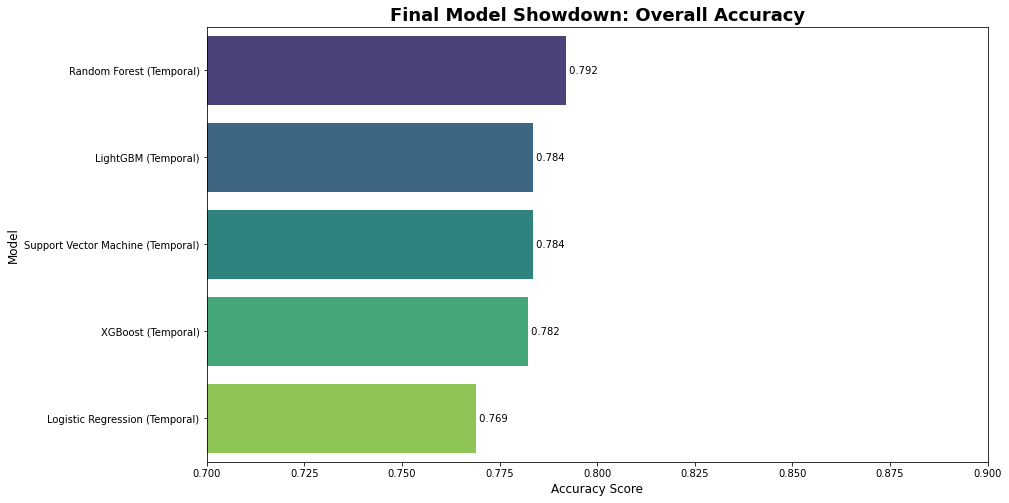

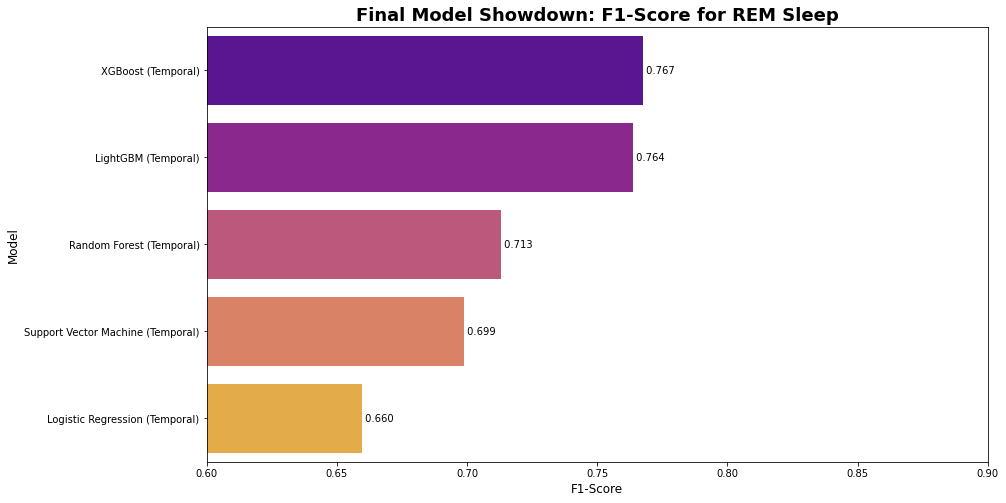


--- Modeling Complete ---


In [8]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Core ML Libraries ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# --- Models ---
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# --- Imbalance Handling ---
from imblearn.over_sampling import SMOTE

# =============================================================================
# --- Configuration ---
# =============================================================================
# The new, powerful training dataset with temporal features.
TRAINING_CSV_PATH = 'master_training_dataset_temporal.csv'
# The folder containing your 3 UNSEEN TEST subject CSV files.
TEST_DATA_FOLDER = './test_subjects/'

TARGET_COLUMN = 'sleep_stage'

# =============================================================================
# --- Helper Functions ---
# =============================================================================
def create_temporal_features(df):
    """
    A helper function to create temporal features for a given dataframe.
    This ensures the test data is processed identically to the training data.
    """
    feature_cols = [col for col in df.columns if col not in ['subject_id', 'sleep_stage', 'is_rem']]
    
    all_subjects_data = []
    for subject, subject_df in df.groupby('subject_id'):
        subject_df = subject_df.reset_index(drop=True)
        prev_epoch_features = subject_df[feature_cols].shift(1)
        prev_epoch_features.columns = [f'{col}_prev' for col in feature_cols]
        next_epoch_features = subject_df[feature_cols].shift(-1)
        next_epoch_features.columns = [f'{col}_next' for col in feature_cols]
        combined_df = pd.concat([subject_df, prev_epoch_features, next_epoch_features], axis=1)
        combined_df.fillna(method='bfill', inplace=True)
        combined_df.fillna(method='ffill', inplace=True)
        all_subjects_data.append(combined_df)
        
    return pd.concat(all_subjects_data, ignore_index=True)

def evaluate_model(model, X_test, y_test, class_names, model_name="Model"):
    """
    Generates a full performance report for a trained classifier and returns key metrics.
    """
    print("\n" + "="*60)
    print(f"--- Performance Report for: {model_name} ---")
    print("="*60)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    print(report)
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16, weight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()
    
    # **NEW:** Return the key metrics for our final comparison
    rem_f1 = f1_score(y_test, y_pred, labels=[list(class_names).index('REM')], average='macro')
    return {'Model': model_name, 'Accuracy': accuracy, 'REM_F1_Score': rem_f1}

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting Final Model Showdown with Temporal Features ---")

# --- 1. Load and Prepare Data ---
print("\n--- Loading Data ---")
try:
    train_df = pd.read_csv(TRAINING_CSV_PATH)
    print(f"Loaded temporal training data: {train_df.shape[0]} epochs")
except FileNotFoundError:
    print(f"ERROR: Training file not found at {TRAINING_CSV_PATH}")
    exit()

# Load, combine, and create temporal features for the test data
search_path = os.path.join(TEST_DATA_FOLDER, '*.csv')
test_files = glob.glob(search_path)
if not test_files:
    print(f"ERROR: No test CSV files found in {TEST_DATA_FOLDER}")
    exit()

raw_test_df = pd.concat([pd.read_csv(f) for f in test_files], ignore_index=True, join='inner')
print(f"Loaded and combined {len(test_files)} raw test subjects: {raw_test_df.shape[0]} epochs")
print("Creating temporal features for the test set...")
test_df = create_temporal_features(raw_test_df)
print("Temporal features for test set created successfully.")

# --- 2. Preprocessing: Align Columns & Separate Features/Labels ---
common_cols = list(set(train_df.columns) & set(test_df.columns))
feature_cols = [col for col in common_cols if col not in ['subject_id', 'sleep_stage', 'is_rem']]

X_train = train_df[feature_cols]
y_train_text = train_df[TARGET_COLUMN]

X_test = test_df[feature_cols]
y_test_text = test_df[TARGET_COLUMN]

# --- 3. Preprocessing: Label Encoding ---
print("\n--- Preprocessing: Encoding Labels ---")
le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
y_test = le.transform(y_test_text)
class_names = le.classes_
print(f"Labels encoded. Class order: {list(class_names)}")

# --- 4. Preprocessing: Feature Scaling ---
print("\n--- Preprocessing: Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. Handling Class Imbalance with SMOTE ---
print("\n--- Handling Class Imbalance with SMOTE ---")
print(f"Original training data shape: {X_train_scaled.shape}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Resampled training data shape: {X_train_resampled.shape}")

# --- 6. Train and Evaluate Models ---
# **NEW:** Create a list to store the results from each model
all_results = []

# --- Model 1: Random Forest ---
print("\n--- Training Model 1: Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)
results = evaluate_model(rf_model, X_test_scaled, y_test, class_names, "Random Forest (Temporal)")
all_results.append(results)

# --- Model 2: XGBoost ---
print("\n--- Training Model 2: XGBoost ---")
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(class_names),
                              use_label_encoder=False, eval_metric='mlogloss', 
                              random_state=42, n_jobs=-1)
xgb_model.fit(X_train_resampled, y_train_resampled)
results = evaluate_model(xgb_model, X_test_scaled, y_test, class_names, "XGBoost (Temporal)")
all_results.append(results)

# --- Model 3: LightGBM ---
print("\n--- Training Model 3: LightGBM ---")
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=len(class_names),
                               random_state=42, n_jobs=-1)
lgb_model.fit(X_train_resampled, y_train_resampled)
results = evaluate_model(lgb_model, X_test_scaled, y_test, class_names, "LightGBM (Temporal)")
all_results.append(results)

# --- Model 4: Support Vector Machine (SVC) ---
print("\n--- Training Model 4: Support Vector Machine (SVC) ---")
svc_model = SVC(random_state=42)
svc_model.fit(X_train_resampled, y_train_resampled)
results = evaluate_model(svc_model, X_test_scaled, y_test, class_names, "Support Vector Machine (Temporal)")
all_results.append(results)

# --- Model 5: Logistic Regression ---
print("\n--- Training Model 5: Logistic Regression ---")
lr_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
lr_model.fit(X_train_resampled, y_train_resampled)
results = evaluate_model(lr_model, X_test_scaled, y_test, class_names, "Logistic Regression (Temporal)")
all_results.append(results)

# --- 7. **NEW:** Final Model Comparison ---
print("\n" + "="*60)
print("--- FINAL MODEL SHOWDOWN: PERFORMANCE COMPARISON ---")
print("="*60)

results_df = pd.DataFrame(all_results).sort_values(by='Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Create a summary plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis', orient='h')
plt.title('Final Model Showdown: Overall Accuracy', fontsize=18, weight='bold')
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.7, 0.9) # Zoom in on the relevant accuracy range
for index, value in enumerate(results_df['Accuracy']):
    plt.text(value, index, f' {value:.3f}', va='center')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='REM_F1_Score', y='Model', data=results_df.sort_values(by='REM_F1_Score', ascending=False), palette='plasma', orient='h')
plt.title('Final Model Showdown: F1-Score for REM Sleep', fontsize=18, weight='bold')
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.6, 0.9) # Zoom in on the relevant F1-score range
for index, value in enumerate(results_df.sort_values(by='REM_F1_Score', ascending=False)['REM_F1_Score']):
    plt.text(value, index, f' {value:.3f}', va='center')
plt.show()


print("\n--- Modeling Complete ---")


--- Starting State-of-the-Art LSTM Model ---
Labels encoded. Found 5 classes: ['N1', 'N2', 'N3', 'REM', 'Wake']

Creating sequences of length 10...
Training sequences created. Shape: (21443, 10, 99)
Test sequences created. Shape: (2572, 10, 99)

--- Handling Class Imbalance with SMOTE ---
Resampled training data shape: (41130, 10, 99)

--- Building the LSTM Model ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           116736    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 10, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)  

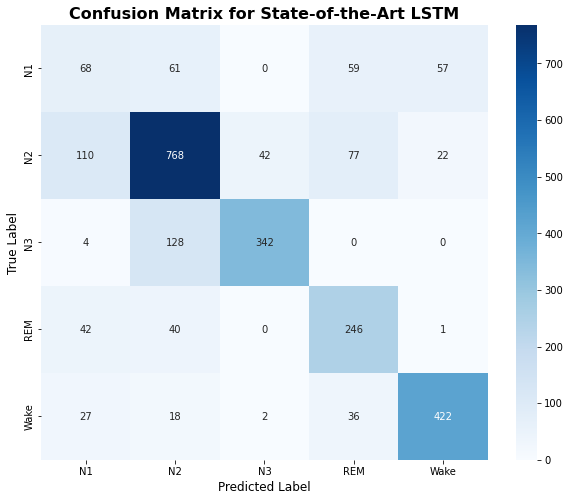


--- Modeling Complete ---


In [9]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Core ML & DL Libraries ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# --- Imbalance Handling ---
from imblearn.over_sampling import SMOTE

# =============================================================================
# --- Configuration ---
# =============================================================================
# We use the original (non-temporal) feature set, as the LSTM will learn
# the temporal patterns itself.
TRAINING_CSV_PATH = 'master_training_dataset_imputed.csv'
TEST_DATA_FOLDER = './test_subjects/'

TARGET_COLUMN = 'sleep_stage'
# The number of previous epochs the LSTM will look at to predict the current one.
SEQUENCE_LENGTH = 10  # This means the model looks at a 5-minute window (10 * 30s)

# =============================================================================
# --- Helper Functions ---
# =============================================================================
def create_sequences(X, y, sequence_length, subject_ids):
    """
    Reshapes the flat feature data into sequences for the LSTM.
    """
    X_seq, y_seq = [], []
    # Group by subject to avoid creating sequences that span across two different people
    data_df = pd.DataFrame(X)
    data_df['subject_id'] = subject_ids
    data_df['label'] = y
    
    for subject, group in data_df.groupby('subject_id'):
        features = group.drop(columns=['subject_id', 'label']).values
        labels = group['label'].values
        for i in range(len(features) - sequence_length):
            X_seq.append(features[i:(i + sequence_length)])
            y_seq.append(labels[i + sequence_length])
            
    return np.array(X_seq), np.array(y_seq)

def evaluate_lstm_model(model, X_test, y_test, class_names, model_name="Model"):
    """
    Generates a full performance report for a trained LSTM classifier.
    """
    print("\n" + "="*60)
    print(f"--- Performance Report for: {model_name} ---")
    print("="*60)
    
    # Get model predictions (probabilities)
    y_pred_proba = model.predict(X_test)
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy:.2%})")
    
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    print(report)
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16, weight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

# =============================================================================
# --- Main Execution ---
# =============================================================================
print("--- Starting State-of-the-Art LSTM Model ---")

# --- 1. Load Data ---
train_df = pd.read_csv(TRAINING_CSV_PATH)
test_files = glob.glob(os.path.join(TEST_DATA_FOLDER, '*.csv'))
test_df = pd.concat([pd.read_csv(f) for f in test_files], ignore_index=True, join='inner')

# --- 2. Preprocessing: Align Columns & Separate Features/Labels ---
common_cols = list(set(train_df.columns) & set(test_df.columns))
feature_cols = [col for col in common_cols if col not in ['subject_id', 'sleep_stage', 'is_rem']]

X_train = train_df[feature_cols]
y_train_text = train_df[TARGET_COLUMN]
train_subjects = train_df['subject_id']

X_test = test_df[feature_cols]
y_test_text = test_df[TARGET_COLUMN]
test_subjects = test_df['subject_id']

# --- 3. Preprocessing: Label Encoding ---
le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
y_test = le.transform(y_test_text)
class_names = le.classes_
n_classes = len(class_names)
print(f"Labels encoded. Found {n_classes} classes: {list(class_names)}")

# --- 4. Preprocessing: Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. Create Sequences for LSTM ---
print(f"\nCreating sequences of length {SEQUENCE_LENGTH}...")
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH, train_subjects)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH, test_subjects)
print(f"Training sequences created. Shape: {X_train_seq.shape}")
print(f"Test sequences created. Shape: {X_test_seq.shape}")

# --- 6. Handling Class Imbalance with SMOTE ---
# SMOTE works on 2D data, so we need to reshape, apply SMOTE, then reshape back.
print("\n--- Handling Class Imbalance with SMOTE ---")
n_samples, n_timesteps, n_features = X_train_seq.shape
X_train_reshaped = X_train_seq.reshape((n_samples, n_timesteps * n_features))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train_seq)
X_train_resampled = X_train_resampled.reshape((-1, n_timesteps, n_features))
print(f"Resampled training data shape: {X_train_resampled.shape}")

# --- 7. Prepare Labels for Keras (One-Hot Encoding) ---
y_train_keras = to_categorical(y_train_resampled, num_classes=n_classes)
y_test_keras = to_categorical(y_test_seq, num_classes=n_classes)

# --- 8. Build the LSTM Model ---
print("\n--- Building the LSTM Model ---")
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, X_train_resampled.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# --- 9. Train the LSTM Model ---
print("\n--- Training the LSTM Model ---")
history = model.fit(X_train_resampled, y_train_keras, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.1, # Use part of training data for validation
                    verbose=1)

# --- 10. Evaluate the Final Model on Unseen Test Data ---
evaluate_lstm_model(model, X_test_seq, y_test_seq, class_names, "State-of-the-Art LSTM")

print("\n--- Modeling Complete ---")
